# Modeling
In this exercise, we will predict activity on mtor ligands. We will use regresion forms of [SVM](https://en.wikipedia.org/wiki/Support-vector_machine) and [Random Forest](https://en.wikipedia.org/wiki/Random_forest). This methods are good, but they allways give you some results, so remember garbage in, garbage out. We will use again
scikit [SVR](https://scikit-learn.org/stable/modules/svm.html#regression) and [RF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest#sklearn.ensemble.RandomForestRegressor).

In [2]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# plots
from matplotlib import pyplot
import seaborn

# other packages
import pandas as pd
import numpy as np
import csv
import re

## Standardization

Before we start with model training, we should clean our data - standardize compounds. In our case, it means removal of salts, inorganics and [neutralization](https://rdkit.readthedocs.io/en/latest/Cookbook.html#neutralizing-charged-molecules). You can use tautomerization or some advanced packages like [molvs](https://molvs.readthedocs.io/en/latest/).

In [4]:
sr = SaltRemover() # from rdkit
m = Chem.MolFromSmiles("[Na+].C(=O)[O-]")
print(Chem.MolToSmiles(sr(m)))

O=C[O-]


In [5]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [6]:
smis=("c1cccc[nH+]1",
      "C[N+](C)(C)C","c1ccccc1[NH3+]",
      "CC(=O)[O-]","c1ccccc1[O-]",
      "CCS",
      "C[N-]S(=O)(=O)C",
      "C[N-]C=C","C[N-]N=C",
      "c1ccc[n-]1",
      "CC[N-]C(=O)CC")
for smi in smis:
    (molSmiles, neutralised) = NeutraliseCharges(Chem.MolFromSmiles(smi))
    print(smi + "->" + Chem.MolToSmiles(molSmiles))

c1cccc[nH+]1->c1ccncc1
C[N+](C)(C)C->C[N+](C)(C)C
c1ccccc1[NH3+]->Nc1ccccc1
CC(=O)[O-]->CC(=O)O
c1ccccc1[O-]->Oc1ccccc1
CCS->CCS
C[N-]S(=O)(=O)C->CNS(C)(=O)=O
C[N-]C=C->C=CNC
C[N-]N=C->C=NNC
c1ccc[n-]1->c1cc[nH]c1
CC[N-]C(=O)CC->CCNC(=O)CC


In [7]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

## Data loading

In [8]:
# some pChEMBL values in our file are not valid floats
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]
# load mtor, we want to remember source of data and Standard and pChEMBLE value (it's transfomed compound activity to "standard" value)
with open("../data/chembl_mtor_ic50.csv") as inp:
    mtor = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in mtor:
        mol = Chem.MolFromSmiles(m["Smiles"])
        if mol:
            m["rdmol"] = mol
            stdmol = standardize(mol)
            m["source"] = "mtor"
            m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
            m["std_rdmol"] = None
            m["Standard Value"] = float(m["Standard Value"]) if float_pattern.match(m["Standard Value"]) else np.NaN
        if stdmol:
            m["std_rdmol"] = stdmol
            m["std_smiles"] = Chem.MolToSmiles(stdmol)
            m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["std_rdmol"],2,nBits=1024)
            for f in lip_func:
                m[f[0]] = f[1](m["std_rdmol"])

In [11]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = []
for m in Chem.SDMolSupplier("../data/drugbank.sdf"):
    if m:
        stdmol = standardize(m)
    else:
        continue    
    if stdmol:
        std_smiles = Chem.MolToSmiles(stdmol)
        drugbank.append({
         "rdmol": m,
         "std_rdmol": stdmol,
         "source": "drugbank",
         "std_smiles": std_smiles,
         "Smiles": Chem.MolToSmiles(m),
         "pChEMBL Value": 0,
         "Standard Value": np.NaN,
         "fps": Chem.GetMorganFingerprintAsBitVect(stdmol, 2, nBits=1024),
         **{f[0]: f[1](stdmol) for f in lip_func}
        })


In [21]:
# let's work with Pandas dataframe
df = pd.DataFrame((*drugbank, *[m for m in mtor if m["std_rdmol"]]), columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "pChEMBL Value", *(f[0] for f in lip_func)])
# adds index as normal column
df.reset_index(level=0, inplace=True)
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )


In [22]:
mx = df["Standard Value"].max()+1
df["Standard Value"] = df["Standard Value"].fillna(mx+1)

## SVR

In [16]:
svr = svm.SVR()
svr.fit(df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["Standard Value"])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [17]:
res = pd.DataFrame(svr.predict(df[(f"MQN_{x}" for x in range(1, 43))])).join(df[["Standard Value", "source"]])
res.columns = ["Prediction", "Standard Value", "Source"]
(res["Prediction"]-res["Standard Value"]).abs().mean()

5800754.479950828

In [18]:
(res[res["Source"]=="mtor"]["Prediction"]-res[res["Source"]=="mtor"]["Standard Value"]).abs().mean()

177579.0504089287

### Let's use some function to get results, we will have lots of models

In [40]:
def get_results(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(data[descriptors])).join(data[[predicted_value, "source"]])
    res.columns = ["Prediction", predicted_value, "Source"]
    print(f"""Average error whole set: {(res["Prediction"]-res[predicted_value]).abs().mean()}
Average error mtor: {(res[res["Source"]=="mtor"]["Prediction"]-res[res["Source"]=="mtor"][predicted_value]).abs().mean()}""")
    return res

In [41]:
res = get_results(svr, df, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 5800754.479950828
Average error mtor: 177579.0504089287


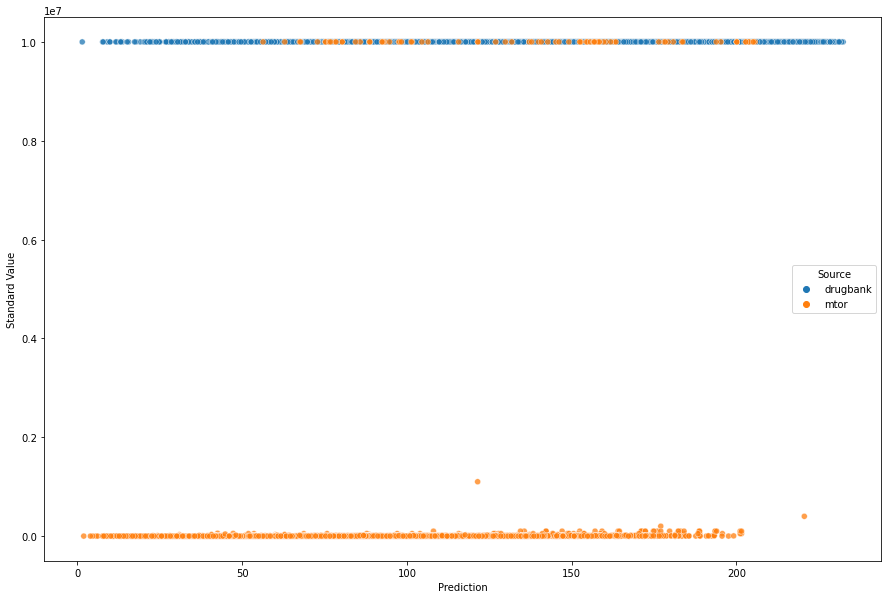

In [42]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

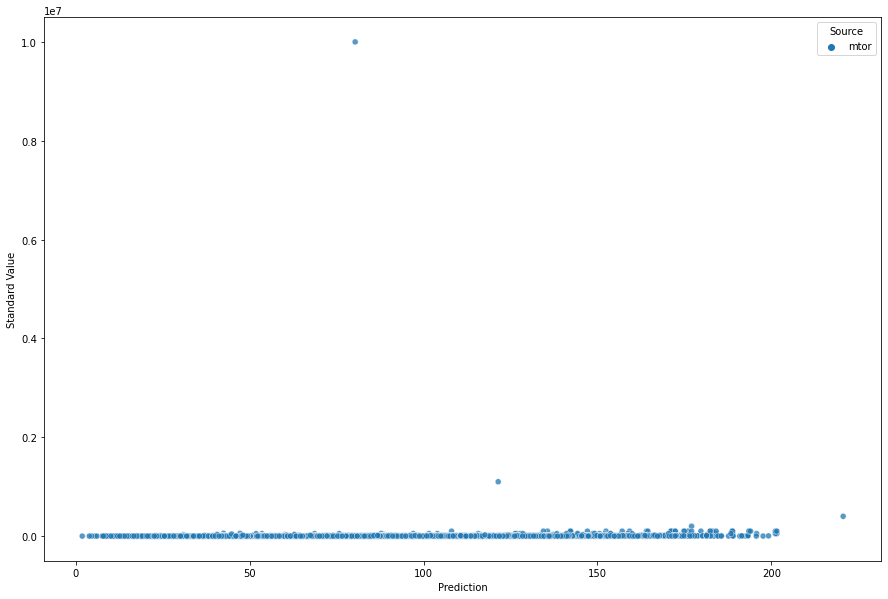

In [43]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res[res["Standard Value"]<mx],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

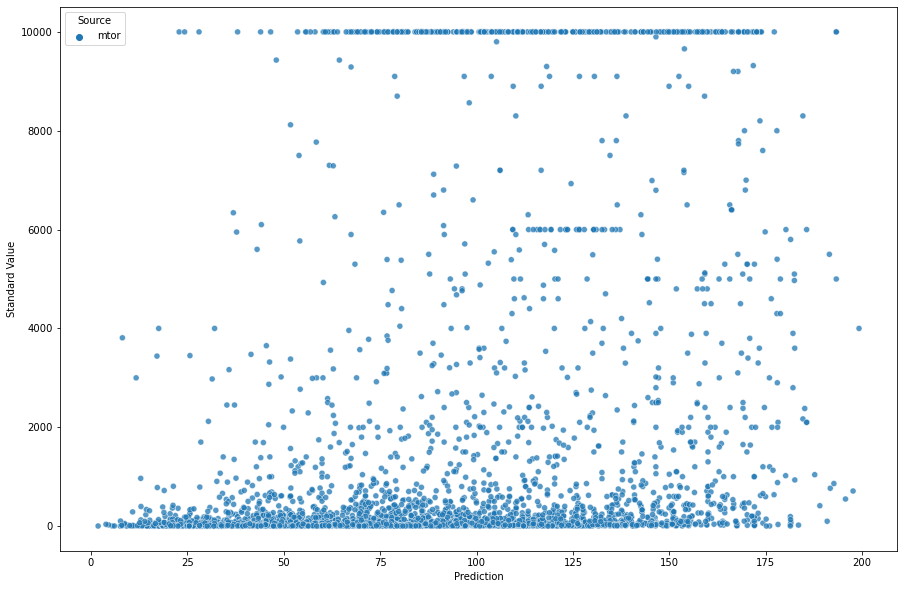

In [44]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res[res["Standard Value"]<mx/1000],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## Random forest

In [18]:
rf = ensemble.RandomForestRegressor()
rf.fit(df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["Standard Value"])

RandomForestRegressor()

In [19]:
res_rf = get_results(rf, df, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 5753042.841007759
Average error mtor: 174503.31772981354


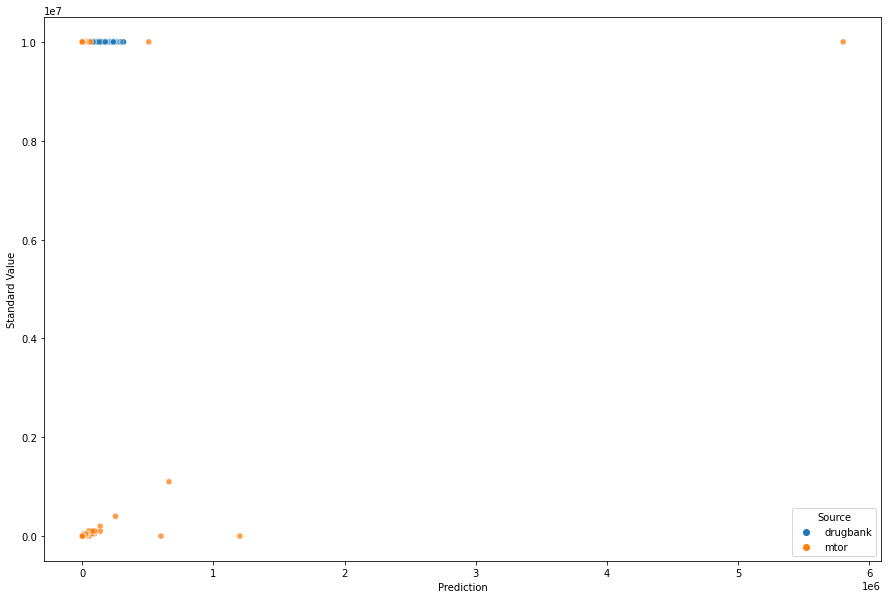

In [20]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

/home/milan/miniconda3/envs/cdd2021/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


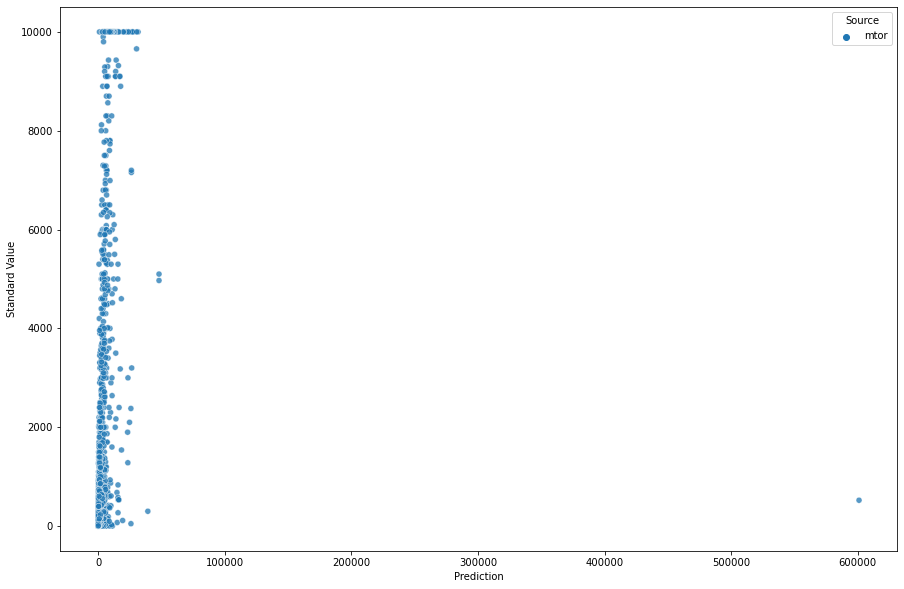

In [21]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf[res_rf["Standard Value"]<mx/1000][res_rf["Prediction"]<1e6],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

You can see the range of values is pretty broad. Maybe, log values will be better. Let's try pChEMBL Value.

## SVR

In [45]:
svr_p = svm.SVR()
svr_p.fit(df[df["pChEMBL Value"]>0][(f"MQN_{x}" for x in range(1, 43))], df[df["pChEMBL Value"]>0]["pChEMBL Value"])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [47]:
res_svr_p = get_results(svr_p, df, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 3.863141480154657
Average error mtor: 1.5635975239531021


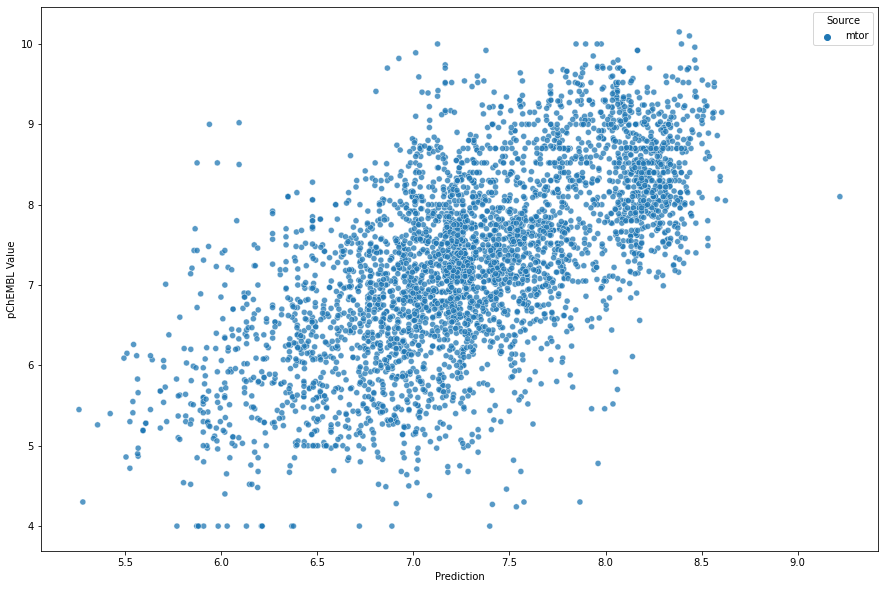

In [58]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_p[res_svr_p["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## SVR with PCA

In [68]:
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca = decomposition.PCA(n_components=42)
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

In [69]:
svr_np = svm.SVR()
svr_np.fit(df[df["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["pChEMBL Value"])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [70]:
res_svr_np = res = get_results(svr_np, df, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 3.48654355416656
Average error mtor: 1.2258767266224164


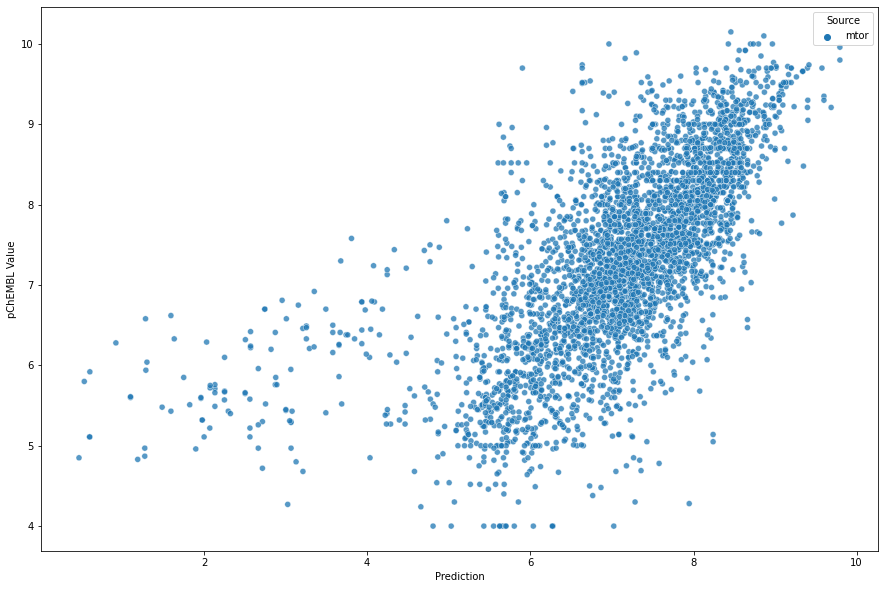

In [71]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_np[res_svr_np["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## SVR with other kernel?

In [29]:
svr_poly = svm.SVR(kernel='poly')
svr_poly.fit(df[df["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["pChEMBL Value"])

SVR(kernel='poly')

In [30]:
res_poly = get_results(svr_poly, df, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 6.652455593248457
Average error mtor: 1.2739092210561116


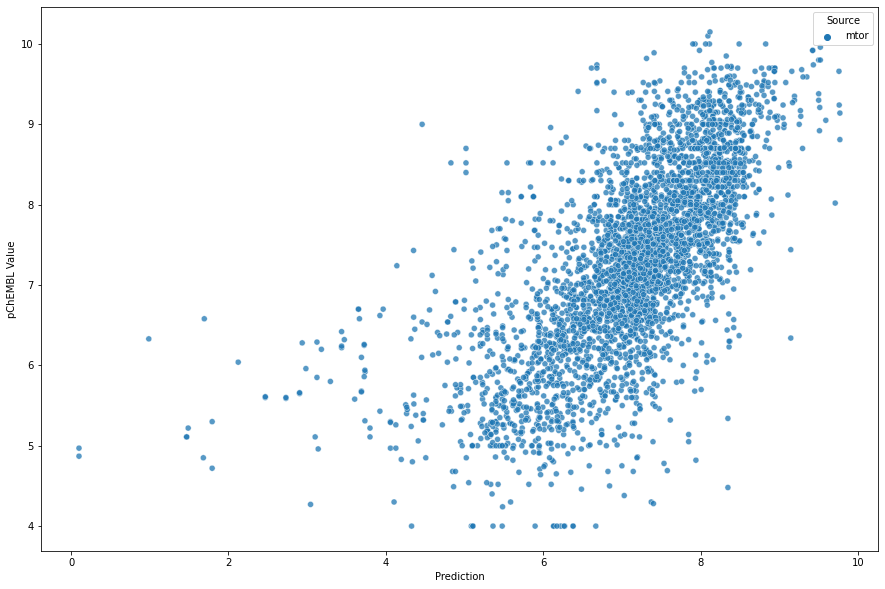

In [31]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_poly[res_poly["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## We need test set
So, we divide our data in some ration (default is 75:25, but 80:20-70:30 is usually OK)

In [32]:
trainset, testset = ms.train_test_split(df[df["pChEMBL Value"]>0])

In [33]:
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)

In [34]:
len(trainset), len(testset)

(2945, 982)

In [35]:
finaly_good_model = ensemble.RandomForestRegressor()
finaly_good_model.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

RandomForestRegressor()

In [36]:
train_results = get_results(finaly_good_model, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.2252630734059345
Average error mtor: 0.2252630734059345


In [37]:
test_results = get_results(finaly_good_model, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.5142285492670955
Average error mtor: 0.5142285492670955


In [38]:
print("R^2: %0.2f" % finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: 0.66
R: 0.81
MSE: 0.48


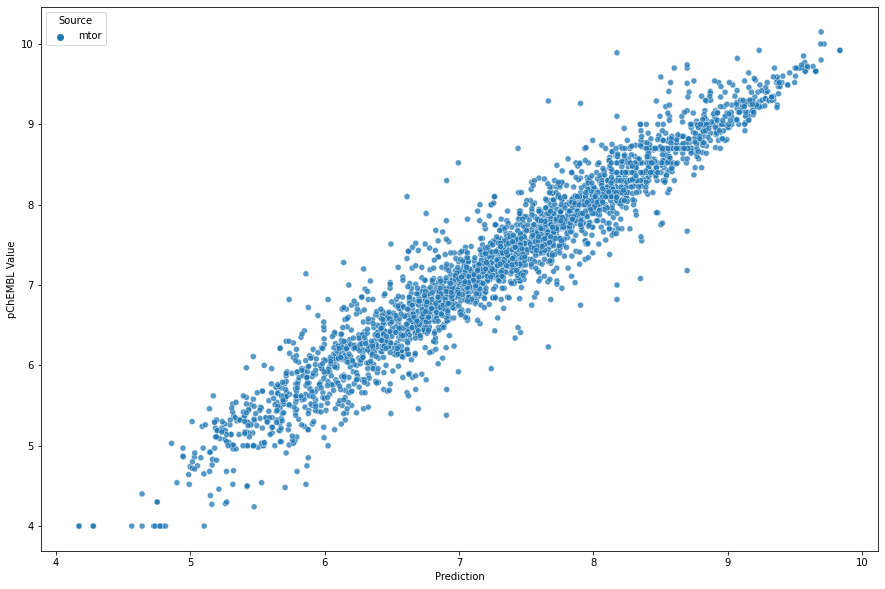

In [39]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=train_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

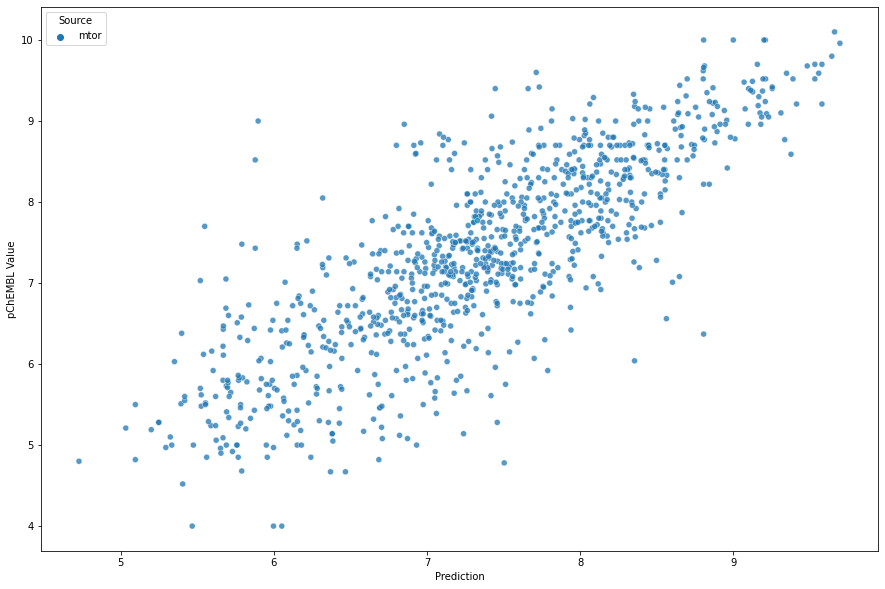

In [40]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## What to do?
* Familiarize yourself with modeling. If mentioned models in this exercise are not enough, you can surely find more methods in scikit-learn. You can use another descriptors, e.g. fingerprints.
* Find some well predictig solution set of model and descriptors on your data

### Data preprocessing

In [9]:
with open("H1.csv") as inp:
    h1 = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in h1:
        mol = Chem.MolFromSmiles(m["Smiles"])
        if mol:
            m["rdmol"] = mol
            stdmol = standardize(mol)
            m["source"] = "h1"
            m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
            m["std_rdmol"] = None
            m["Standard Value"] = float(m["Standard Value"]) if float_pattern.match(m["Standard Value"]) else np.NaN
        if stdmol:
            m["std_rdmol"] = stdmol
            m["std_smiles"] = Chem.MolToSmiles(stdmol)
            m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["std_rdmol"],2,nBits=1024)
            for f in lip_func:
                m[f[0]] = f[1](m["std_rdmol"])

In [13]:
df_h1 = pd.DataFrame((*drugbank, *[m for m in h1 if m["std_rdmol"]]), columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "pChEMBL Value", *(f[0] for f in lip_func)])

df_h1.reset_index(level=0, inplace=True)
df_h1 = df_h1.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df_h1["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

In [14]:
mx_h1 = df_h1["Standard Value"].max()+1
df_h1["Standard Value"] = df_h1["Standard Value"].fillna(mx_h1+1)

### Support Vector Machine 

In [15]:
def get_results_h1(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(data[descriptors])).join(data[[predicted_value, "source"]])
    res.columns = ["Prediction", predicted_value, "Source"]
    print(f"""Average error whole set: {(res["Prediction"]-res[predicted_value]).abs().mean()}
Average error H1: {(res[res["Source"]=="h1"]["Prediction"]-res[res["Source"]=="h1"][predicted_value]).abs().mean()}""")
    return res

Support Vector machine as implemented in sklearn.svm.SVR has number of arguments. The one argument that I am familiar with is 'kernel' which specifies type of kernel function used for prediction. By default it takes RBF, which is a specific kind of Gaussian kernel. However, I want to choose such kernel function which minimizes absolute error.

#### RBF

In [16]:
svr_h1 = svm.SVR()
svr_h1.fit(df_h1[df_h1["Standard Value"]<mx_h1][(f"MQN_{x}" for x in range(1, 43))], df_h1[df_h1["Standard Value"]<mx_h1]["Standard Value"])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [17]:
res_h1 = get_results_h1(svr_h1, df_h1, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 1410090.7612026455
Average error H1: 961886.2141225099


#### Polynomial

In [18]:
svr_h1 = svm.SVR(kernel='poly')
svr_h1.fit(df_h1[df_h1["Standard Value"]<mx_h1][(f"MQN_{x}" for x in range(1, 43))], df_h1[df_h1["Standard Value"]<mx_h1]["Standard Value"])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [19]:
res_h1 = get_results_h1(svr_h1, df_h1, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 1410081.5451032678
Average error H1: 961874.7915541268


#### Linear

In [20]:
svr_h1 = svm.SVR(kernel='linear')
svr_h1.fit(df_h1[df_h1["Standard Value"]<mx_h1][(f"MQN_{x}" for x in range(1, 43))], df_h1[df_h1["Standard Value"]<mx_h1]["Standard Value"])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [21]:
res_h1 = get_results_h1(svr_h1, df_h1, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 1409624.3073053884
Average error H1: 961632.6971361485


#### Sigmoid

In [22]:
svr_h1 = svm.SVR(kernel='sigmoid')
svr_h1.fit(df_h1[df_h1["Standard Value"]<mx_h1][(f"MQN_{x}" for x in range(1, 43))], df_h1[df_h1["Standard Value"]<mx_h1]["Standard Value"])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [23]:
res_h1 = get_results_h1(svr_h1, df_h1, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 1410096.3110671374
Average error H1: 961890.4727976446


It seems that that linear kernel function gives the lowest error and therefore, I will use it for prediction.

In [24]:
svr_h1 = svm.SVR(kernel='linear')
svr_h1.fit(df_h1[df_h1["Standard Value"]<mx_h1][(f"MQN_{x}" for x in range(1, 43))], df_h1[df_h1["Standard Value"]<mx_h1]["Standard Value"])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [25]:
res_h1 = get_results_h1(svr_h1, df_h1, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 1409624.3073053884
Average error H1: 961632.6971361485


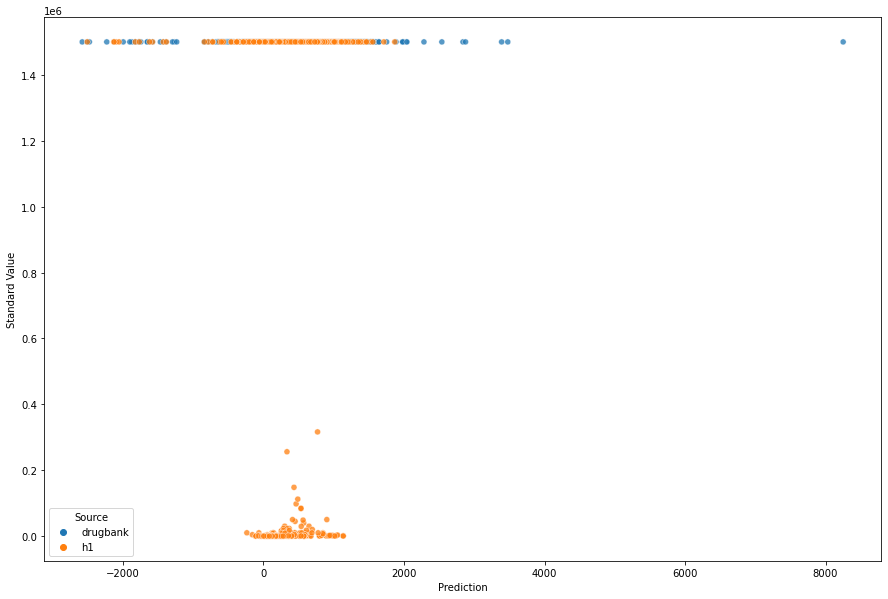

In [26]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_h1,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

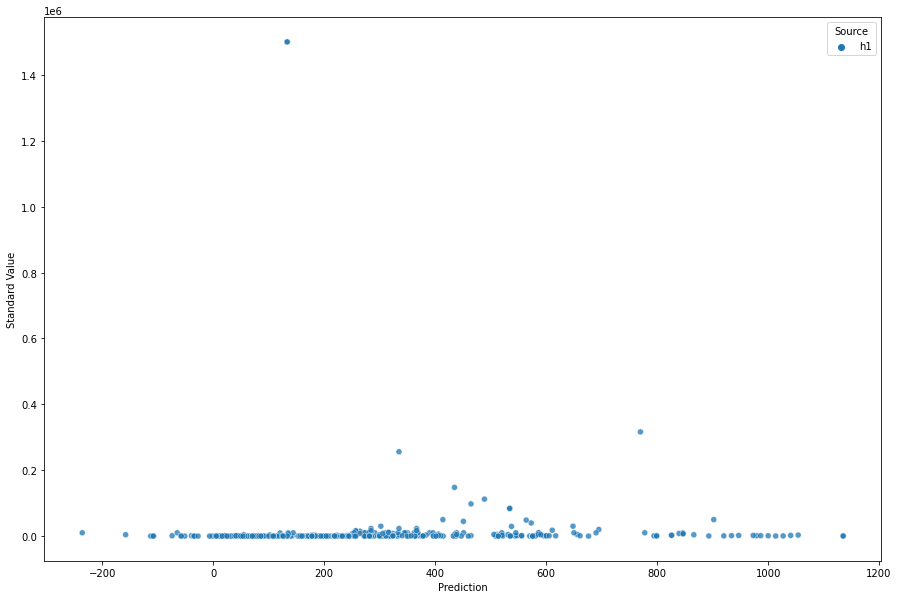

In [27]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_h1[res_h1["Standard Value"]<mx_h1],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

We can see two outliers in top center area, that are probably of a low activity and would be worth removing from the data set.

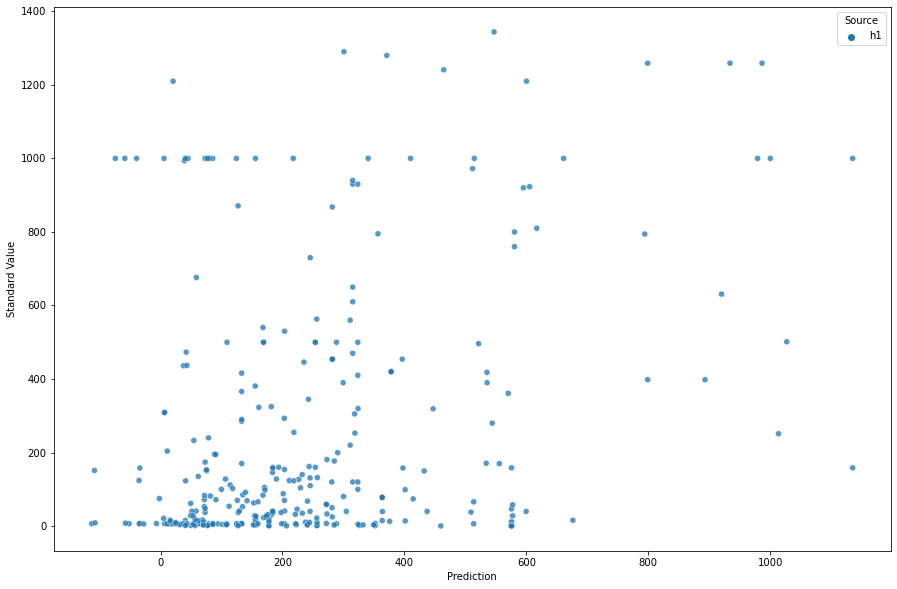

In [28]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_h1[res_h1["Standard Value"]<mx_h1/1000],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

This graph seems a little bit better than the one for *mtor* but it is still very bad. In ideal scenario, the points would lay on a diagonal connecting lower left and upper right corner.

Let's try to predict pCHEMBL !

#### RBF

In [29]:
svr_p_h1 = svm.SVR()
svr_p_h1.fit(df_h1[df_h1["pChEMBL Value"]>0][(f"MQN_{x}" for x in range(1, 43))], df_h1[df_h1["pChEMBL Value"]>0]["pChEMBL Value"])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [30]:
res_svr_p_h1 = get_results_h1(svr_p_h1, df_h1, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 6.348880474575674
Average error H1: 4.917521870678791


This looks much better than previous prediction.

#### Polynomial

In [31]:
svr_p_h1 = svm.SVR(kernel='poly')
svr_p_h1.fit(df_h1[df_h1["pChEMBL Value"]>0][(f"MQN_{x}" for x in range(1, 43))], df_h1[df_h1["pChEMBL Value"]>0]["pChEMBL Value"])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [32]:
res_svr_p_h1 = get_results_h1(svr_p_h1, df_h1, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 6.976911875400531
Average error H1: 5.431583181270249


#### Linear

In [33]:
svr_p_h1 = svm.SVR(kernel='linear')
svr_p_h1.fit(df_h1[df_h1["pChEMBL Value"]>0][(f"MQN_{x}" for x in range(1, 43))], df_h1[df_h1["pChEMBL Value"]>0]["pChEMBL Value"])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [34]:
res_svr_p_h1 = get_results_h1(svr_p_h1, df_h1, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 5.776608427513912
Average error H1: 4.5314306690043


Linear kernel is the best again.

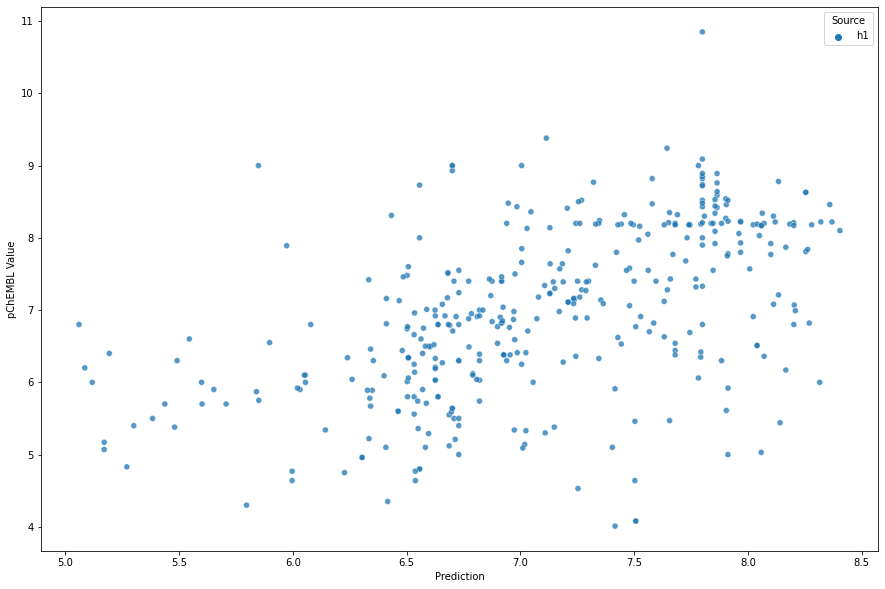

In [35]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_p_h1[res_svr_p_h1["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

This is still not the kind of graph we would want. :-(

### SVR with PCA

In [36]:
norm_h1 = preprocessing.normalize(df_h1[(f"MQN_{x}" for x in range(1, 43))])
pca = decomposition.PCA(n_components=42)
pca.fit(norm_h1)
df_h1 = df_h1.join(pd.DataFrame(pca.transform(norm_h1), columns=[f"nPCA_{x}" for x in range(1, 43)]))

#### RBF

In [43]:
svr_np_h1 = svm.SVR()
svr_np_h1.fit(df_h1[df_h1["Standard Value"]<mx_h1][(f"nPCA_{x}" for x in range(1, 43))], df_h1[df_h1["Standard Value"]<mx_h1]["pChEMBL Value"])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [44]:
res_svr_np_h1 = get_results_h1(svr_np_h1, df_h1, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 5.642308864385072
Average error H1: 4.374457146165439


#### Polynomial

In [39]:
svr_np_h1 = svm.SVR(kernel = 'poly')
svr_np_h1.fit(df_h1[df_h1["Standard Value"]<mx_h1][(f"nPCA_{x}" for x in range(1, 43))], df_h1[df_h1["Standard Value"]<mx_h1]["pChEMBL Value"])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [40]:
res_svr_np_h1 = get_results_h1(svr_np_h1, df_h1, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 6.444386181616208
Average error H1: 4.687554454458654


#### Linear

In [41]:
svr_np_h1 = svm.SVR(kernel = 'linear')
svr_np_h1.fit(df_h1[df_h1["Standard Value"]<mx_h1][(f"nPCA_{x}" for x in range(1, 43))], df_h1[df_h1["Standard Value"]<mx_h1]["pChEMBL Value"])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [42]:
res_svr_np_h1 = get_results_h1(svr_np_h1, df_h1, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 6.295942857729801
Average error H1: 4.891501934499278


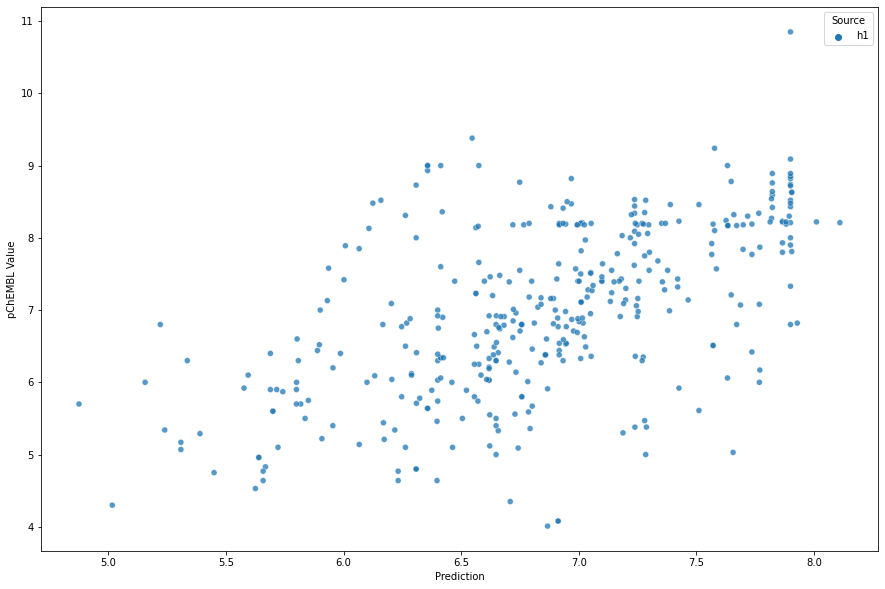

In [45]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_np_h1[res_svr_np_h1["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

:-( okay, time to give up playing with SVR.

### Random Forest

In [46]:
rf_h1 = ensemble.RandomForestRegressor()
rf_h1.fit(df_h1[df_h1["Standard Value"]<mx_h1][(f"MQN_{x}" for x in range(1, 43))], df_h1[df_h1["Standard Value"]<mx_h1]["Standard Value"])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [47]:
res_rf_h1 = get_results_h1(rf_h1, df_h1, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 1369395.1507958027
Average error H1: 932876.52847343


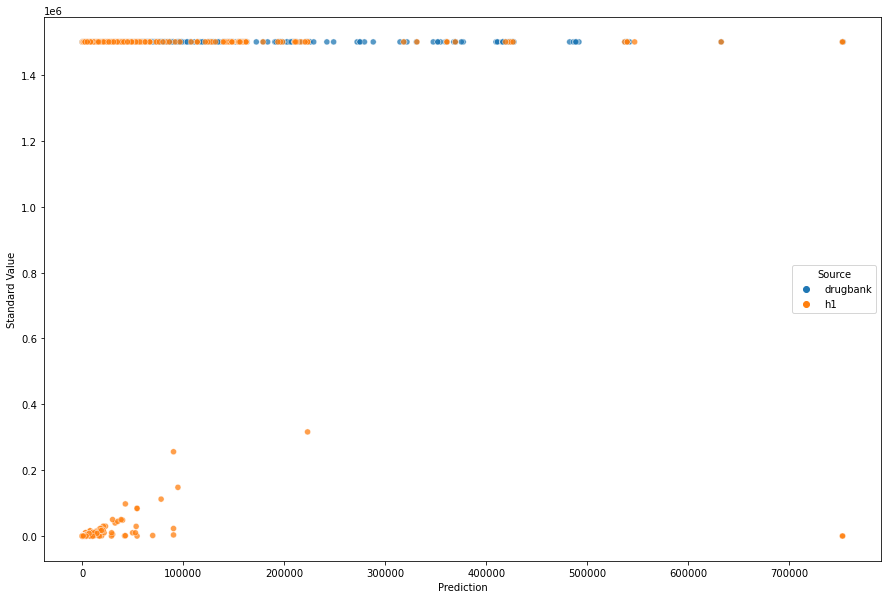

In [48]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf_h1,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

C:\Users\Lucie\anaconda3\envs\new-rdkit-env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


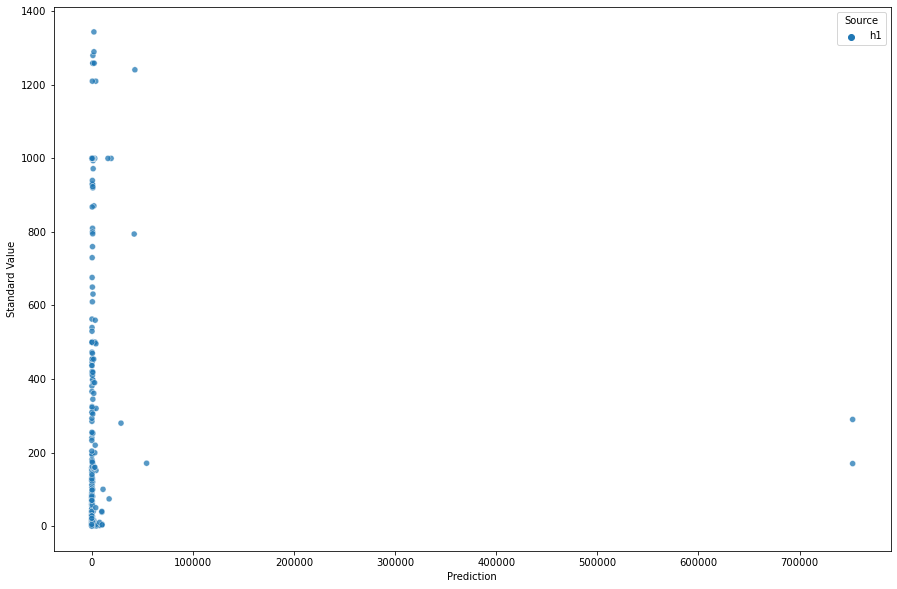

In [49]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf_h1[res_rf_h1["Standard Value"]<mx_h1/1000][res_rf_h1["Prediction"]<1e6],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### Test and train set

In [50]:
trainset, testset = ms.train_test_split(df_h1[df_h1["pChEMBL Value"]>0])
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)
len(trainset), len(testset)

(287, 96)

In [51]:
df_h1[df_h1["pChEMBL Value"]>0].shape[0]

383

Huh, this I have much less rows with pCHEMBl > 0 in my data set than I thought... But let's try anyway.

In [52]:
rf_model = ensemble.RandomForestRegressor()
rf_model.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [53]:
train_results = get_results_h1(rf_model, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.3899400164955118
Average error H1: 0.3899400164955118


In [54]:
test_results = get_results_h1(rf_model, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.6428030318592074
Average error H1: 0.6428030318592074


In [55]:
print("R^2: %0.2f" % rf_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"]))
print("R: %0.5f" % np.sqrt(rf_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: 0.35
R: 0.59038
MSE: 0.77


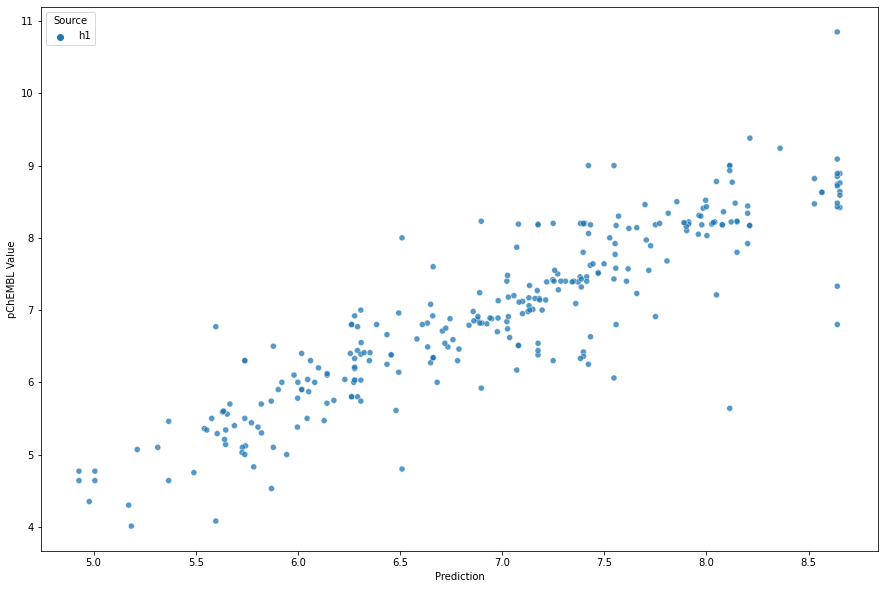

In [56]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=train_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

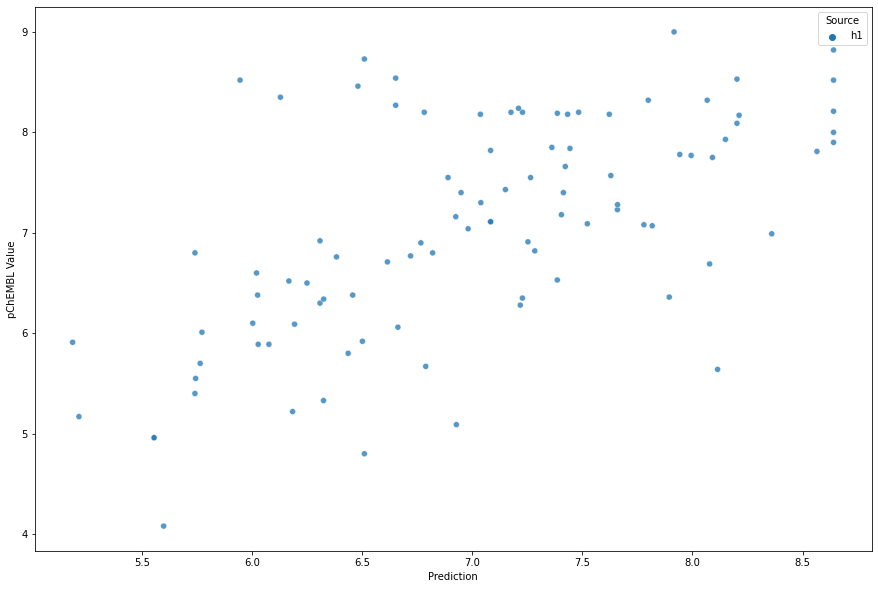

In [57]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Train set result seems plausible on plot. The test set is a bit worse.

### Morgan fingerprints as explanatory variable

In [61]:
df_h1_only = df_h1[df_h1.source != 'drugbank']

In [64]:
pchembl_df = df_h1_only[df_h1_only["pChEMBL Value"]>0]
pchembl_df.shape[0]

383

In [66]:
X = pchembl_df['fps'].to_list()
Y = pchembl_df['pChEMBL Value'].to_list()

In [67]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, Y, test_size=0.3, random_state=0)

#### Random Forest

In [68]:
rf_model = ensemble.RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [69]:
y_pred = rf_model.predict(X_test)

In [70]:
res = pd.DataFrame({'pChEMBL Value':y_test, 'Predicted':y_pred})
res.head()

,pChEMBL Value,Predicted
0,5.33,6.024400
1,6.53,7.048467
2,8.78,7.517867
3,6.30,5.898537
4,6.19,6.198292


In [71]:
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

Mean Squared Error: 1.3880376498003486


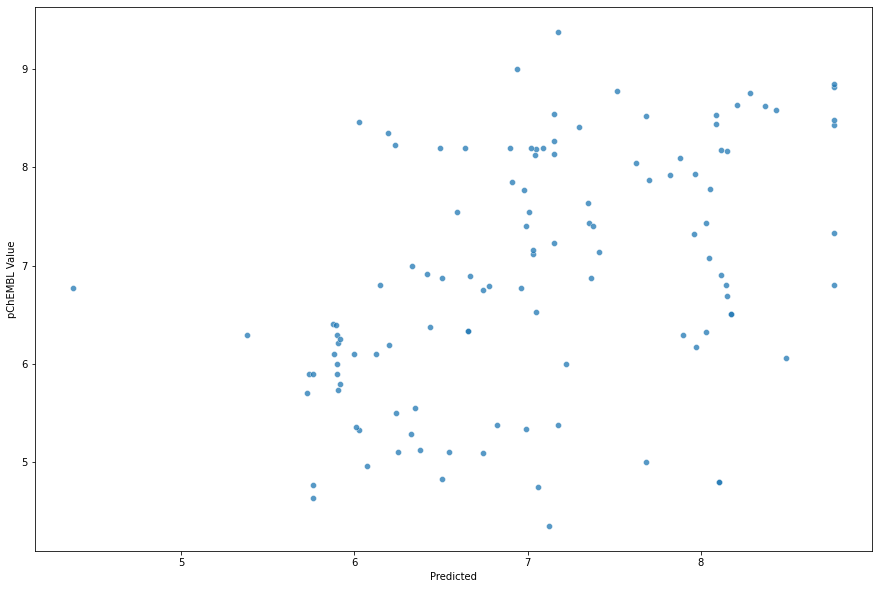

In [72]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Predicted",
                      y="pChEMBL Value",
                      data=res,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

MSE is slightly worse compared to MQN approach. That is the opposite of what I expected...

Maybe the default parameters of random forest are not performing well. I will use cross validation in order to tune parameters to see if it improves the model.

In [74]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [78]:
rf = ensemble.RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [79]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [80]:
best_model = rf_random.best_estimator_

In [83]:
y_pred = best_model.predict(X_test)

In [84]:
res = pd.DataFrame({'pChEMBL Value':y_test, 'Predicted':y_pred})

In [85]:
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

Mean Squared Error: 1.1575477540470989


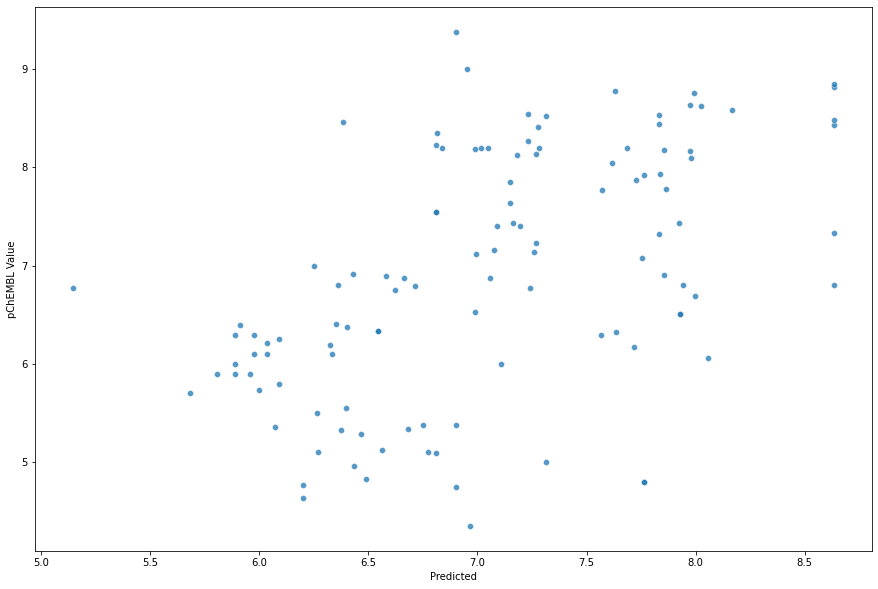

In [86]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Predicted",
                      y="pChEMBL Value",
                      data=res,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

By tuning random forest hyperparameters I managed to improve MSE from 1.38 to 1.15

#### Support vector machine

In [95]:
kernels = ['rbf', 'sigmoid', 'poly', 'linear']
random_grid = {'kernel' : kernels, 
               'C':[1.5, 10],
               'gamma': [1e-7, 1e-4],
               'epsilon':[0.1,0.2,0.5,0.3]}

In [96]:
svr = svm.SVR()
svr_random = RandomizedSearchCV(estimator = svr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

svr_random.fit(X_train, y_train)

C:\Users\Lucie\anaconda3\envs\new-rdkit-env\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   30.1s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'C': [1.5, 10],
                                        'epsilon': [0.1, 0.2, 0.5, 0.3],
                                        'gamma': [1e-07, 0.0001],
                                        'kernel': ['rbf', 'sigmoid', 'poly',
                                                   'linear']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [97]:
svr_random.best_params_

{'kernel': 'rbf', 'gamma': 0.0001, 'epsilon': 0.5, 'C': 10}

In [98]:
best_model = rf_random.best_estimator_

In [99]:
y_pred = best_model.predict(X_test)

In [100]:
res = pd.DataFrame({'pChEMBL Value':y_test, 'Predicted':y_pred})
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

Mean Squared Error: 1.1575477540470989


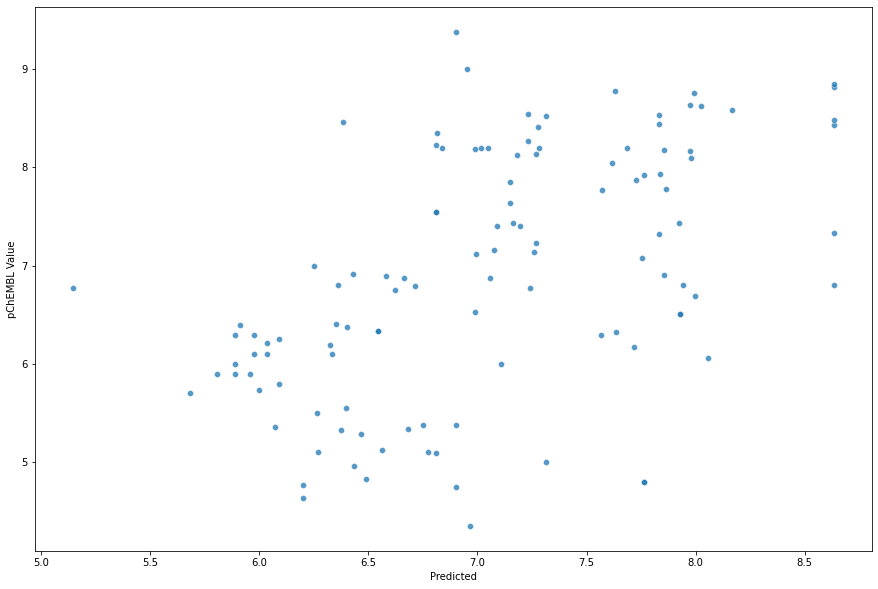

In [101]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Predicted",
                      y="pChEMBL Value",
                      data=res,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

This is actually better than what I expected from SVR. 

![giraffe is happy because you optimized parameters](happy-giraffe.jpg)